In [1]:
import numpy as np
import pandas as pd
import json
from os import listdir
import re
from scipy.linalg import eig
import matplotlib.pyplot as plt
from string import ascii_uppercase
import unidecode

In [2]:
def pca(X):
    ''' Principal Components Analysis '''
    cov_matrix = np.cov(X.T) # Transpose b/c np.cov assumes row vars.
    evals, evecs = eig(cov_matrix)
    idcs = np.argsort(evals)[::-1]
    evecs = evecs.real[:, idcs]
    evals = evals.real[idcs]

    return evecs, evals

In [3]:
def preprocess(df):

    old_vals = ['Strongly Disagree',
                'Disagree',
                'Uncertain',
                'Agree',
                'Strongly Agree',
                'No Opinion',
                'Did Not Answer',
                'Did Not Vote',
                'Did not answer',
                None]
    new_vals = [-1.5,
                -1,
                0,
                1,
                1.5,
                np.nan,
                np.nan,
                np.nan,
                np.nan,
                np.nan]

    df = df.replace(old_vals, new_vals)

    # Only retain responders with > 75% response rate
    num_questions = len(df.columns)
    df = df[df.notnull().sum(axis=1) > (num_questions * 0.75)]

    # Replace remaining nans with the column mean
    df = df.fillna(df.mean())

    df = df.sort_index()
    return df

In [4]:
year = '2021'
survey_dir = f'{year}_surveys'

In [183]:
fnames_to_slugs = {
'2020-10-06-US-EEP-Economic-Recovery.csv': 'economic-recovery',
'2020-10-13-US-EEP-Tax-Proposals.csv': 'tax-proposals',
'2020-10-21-US-EEP-Auction-Theory.csv': 'auction-theory-2',
'2020-11-03-US-EEP-Antitrust-in-the-Digital-Economy.csv': 'antitrust-in-the-digital-economy',
'2020-11-24-US-EEP-Student-Debt-Forgiveness.csv': 'student-debt-forgiveness',
'2020-12-08-US-EEP-Personnel-Economics.csv': 'personnel-economics',
'2020-12-22-US-EEP-Antitrust-Action.csv': 'antitrust-action',
'2021-01-13-US-EEP-After-Brexit.csv': 'after-brexit',
'2021-02-02-US-EEP-The-US-Minimum-Wage.csv': 'the-us-minimum-wage',
'2021-02-08-US-EEP-Coronavirus-Relief.csv': 'coronavirus-relief',
'2021-02-23-US-EEP-Short-Positions.csv': 'short-positions',
'2021-03-09-US-EEP-Pricing-Emissions.csv': 'pricing-emissions',
'2021-03-23-US-EEP-Tackling-Obesity.csv': 'tackling-obesity-2',
}

# WILO: I NEED TO FIND A WAY TO DISTRIBUTE THE SLUGS OVER QUESTIONS, WHEN OFTEN THERE ARE MORE THAN ONE QUESTION PER SLUG. PROBABLY WILL NEED TO CREATE A NEW SLUG LIST WITH LENGHT OF LEN(QUESTIONS)

In [185]:
fnames = sorted(fnames_to_slugs.keys())

In [218]:
qdfs = []
slugs = []
for fname in fnames:
    qdf = pd.read_csv(survey_dir + '/' + fname)
    qdf = qdf.set_index(qdf['First Name'].str.cat(qdf['Last Name'], sep=' '))
    drop_columns = [col for col in qdf.columns if 'Confidence in this topic' in col or 'Please explain your' in col or 'Unnamed' in col]
    drop_columns += ['First Name', 'Last Name']
    qdf = qdf.drop(columns=drop_columns)
    qdf = qdf[qdf.index.notnull()]
    n_cols = len(qdf.columns)
    if n_cols > 1:
        qdf.columns = [f"Part {ascii_uppercase[i]}: {col}" for i, col in enumerate(qdf.columns)]
    
    qdfs += [qdf]
    for col in qdf.columns:
        slugs += [fnames_to_slugs[fname]]
df = pd.concat(qdfs, axis=1)
df.columns = [f"{i+1}. {col}" for i, col in enumerate(df.columns)]


In [220]:
df = preprocess(df)


In [221]:
X_raw = np.array(df).astype(float)
q_means = X_raw.mean(axis=0)
q_sds = X_raw.std(axis=0)

In [222]:
# Separate responder IDs from row names
responder_ids = list(range(len(df)))

# Compute +/- 2SD for each question. For yellow highlights.
X_raw = np.array(df).astype(float)
q_means = X_raw.mean(axis=0)
q_sds = X_raw.std(axis=0)
igm_top_range =    2 * q_sds # Responses will be centered with q_means in .js
igm_bot_range = (-2) * q_sds # Responses will be centered with q_means in .js

# Centering the questions
X = X_raw - X_raw.mean(axis=0)

# Run PCA and compute 2D projection
evecs, evals = pca(X)

In [223]:
# Sign flipping so politically left is on the left
if year == '2021':
    evecs[:,0] = -evecs[:,0] #X
    evecs[:,1] = -evecs[:,1]

# Compute each economists projection in 2D space.
proj = np.dot(X, evecs[:, 0:2])

# User info dict
user_info = {'name': 'You',
             'x': 0,
             'y': 0,
             'responder_id': 0}

In [224]:
# Get correlation matrix, sorted by position on x-axis.
pc1_order = np.argsort(proj[:, 0])
corr_mat = np.corrcoef(X_raw[pc1_order, :])

# List of responder info dicts, including user dict
points = [user_info]
assert(len(df)==len(proj))
for i in range(len(proj)):
    responder_info = {'name': df.index[i],
                      'x': proj[i, 0],
                      'y': proj[i, 1],
                      'short_name': unidecode.unidecode(df.index[i].lower().replace(' ', '-')),
                      'pc1_order': int(np.argwhere(pc1_order == i))}
    points.append(responder_info)

In [225]:
out = {}
out['points'] = points
out['q_slugs'] = slugs
out['questions'] = [re.sub(r"\(0+", "(", col) for col in df.columns]
out['q_means'] = list(q_means)
out['xweights'] = list(evecs[:, 0])
out['yweights'] = list(evecs[:, 1])
out['X'] = [['%.2f' % el for el in row] for row in X.tolist()]
out['corr_mat'] = [['%.2f' % el for el in row]
                   for row in corr_mat.tolist()]
out['igm_top_range'] = ['%.2f' % el for el in igm_top_range]
out['igm_bot_range'] = ['%.2f' % el for el in igm_bot_range]

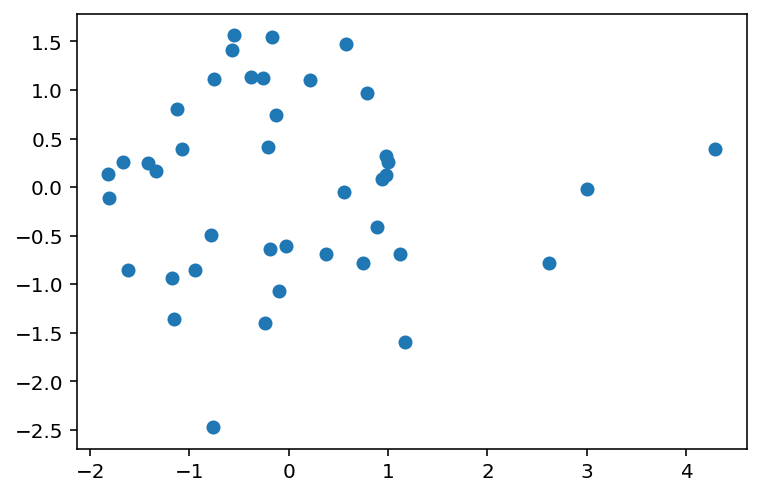

In [226]:
# Write to file
f = open("pca_results_" + year + ".json", "w")
json.dump(out, f, indent=2)
f.close()

# Plot responders in 2D space
plt.figure()
plt.scatter(proj[:, 0], proj[:, 1])
plt.show()

In [227]:
out

{'points': [{'name': 'You', 'x': 0, 'y': 0, 'responder_id': 0},
  {'name': 'Aaron Edlin',
   'x': 0.5778885278742653,
   'y': 1.477502290644358,
   'short_name': 'aaron-edlin',
   'pc1_order': 28},
  {'name': 'Abhijit Banerjee',
   'x': -1.4146852694952619,
   'y': 0.24885749375415378,
   'short_name': 'abhijit-banerjee',
   'pc1_order': 4},
  {'name': 'Alan Auerbach',
   'x': 0.9788415139786616,
   'y': 0.3244978451332813,
   'short_name': 'alan-auerbach',
   'pc1_order': 33},
  {'name': 'Amy Finkelstein',
   'x': -0.023860318500403398,
   'y': -0.6108135092513126,
   'short_name': 'amy-finkelstein',
   'pc1_order': 24},
  {'name': 'Angus Deaton',
   'x': -0.7582911583373987,
   'y': -2.474316905586959,
   'short_name': 'angus-deaton',
   'pc1_order': 12},
  {'name': 'Anil Kashyap',
   'x': 0.8881015453916904,
   'y': -0.41151349729769127,
   'short_name': 'anil-kashyap',
   'pc1_order': 31},
  {'name': 'Austan Goolsbee',
   'x': -1.1565737680472972,
   'y': -1.3569063490763762,
   's